# Attrition Analysis

You have worked hard to build a loyal customer base or a loyal employee base. You do not want the A players, the loyal spokespeople, to churn away from your good business. After all, customers and employees are your lifeblood. How do you preempt possible churn of your employees and customers ahead of time and put effective retention strategies in place? Past attritions reveal a pattern that can used to identify pre-eminent causes for churn that can translate into a specific renetion strategy. Underneath, we show an example of employee attrition on simulated data to understand leading causes of churn. 

We will use data/analysis from https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/ to demonstrate attrition models. Please remember this is a statistical model and does not consider the events or the temporal sequence that led to attrition. Most analyes use both quantitative methods as well as survival models.

## 1. Download data

In [1]:
# Download the data
uri = 'https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-HR-Employee-Attrition.xlsx'
attrition_pd = pd.read_excel(uri)

pd_display(attrition_pd, "Simulated employee churn data")

,Age,Attrition,BusinessTravel,DailyRate,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,...,6,4,0,5
1,49,No,Travel_Frequently,279,...,10,7,1,7
2,37,Yes,Travel_Rarely,1373,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1467,27,No,Travel_Rarely,155,...,6,2,0,3
1468,49,No,Travel_Frequently,1023,...,9,6,0,8
1469,34,No,Travel_Rarely,628,...,4,3,1,2


## 2. Explore data

Let us explore the data to study the type, distributions and general statistics besides the fact that there are 35 recorded attributes and 1470 observations of data.

In [2]:
#Print attributes of the data and their legend
pd.DataFrame(
    zip(attrition_pd.columns, attrition_pd.dtypes),
    columns=['Attribute', 'Data Type']).set_index('Attribute').T

Attribute,Age,Attrition,BusinessTravel,DailyRate,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Data Type,int64,object,object,int64,...,int64,int64,int64,int64


The data contains 
* Attrition -- Label attribute (predicted variable)
* Age -- Continuous variable  (are older employees more likely to attrite than younger employees?)
* Business Travel -- Frequency of travel; are road-warriors more likely to attrite than others?
* Daily Rate -- Are compensated employees more satisfied?
* Department -- does the field of employment make a difference?
* Distance from Home -- is long haul commute a likely indicator for employee frustration?
* Education level -- An ordinal rating for level of education. Is education offering better opportunities to lure employees away?
* Education Field -- Is academic field an indicator for market appetite of skills?
* Employee Count -- duh -- a count of 1 employee is 1. Please ignore this attribute.
* Employee Number -- Employee ID; ignore since this is a apriori ID and has no bearing on the unless an employee attrites because they do not like their number. More likely this is an ID attribute and deserves to be thrown out.
* Environment Satisfaction -- A score for employee satisfaction from previous survey -- the company's environment in general. Of course, higher the satisfaction, the lesser the attrition.
* Gender -- is gender likely a factor? Does gender contribute to churn/volatile qualities?
* Hourly Rate -- Are compensated employees more satisfied? This is of course redundant in view of the daily rate and monthly rate. How do we consolidate all these measures of the compensation into a singular attribute?
* Job Involvement -- How hands on are the employees? Are involved employees more satisfied?
* Job Level -- do executives face different pressures that forces involuntary attrition?
* Job Role -- Does title make a difference? This is probably redundant considering department and the job title; but albeit let us keep it in analysis
* Job Satisfaction -- past satisfaction score from survey about their specific job. I guess this factor can be confounded with environment satisfaction because it is hard to isolate one's job from company overall.
* MaritalStatus -- Do single individuals more likely to attritte because of the socio-econo-emotional independence?
* Monthly Income -- How is this different than monthly rate or daily rate or hourly rate? Not sure. Let us leave it in.
* Monthly Rate --  -- Are compensated employees more satisfied? This is of course redundant in view of the daily rate and hourly rate. How do we consolidate all these measures of the compensation into a singular attribute?
* NumCompaniesWorked -- how many companies in the past have employees rotated? This is meaningless unless we also take into account the total experience duration into account.
* Over18 -- is the employee an adult? All employees are adults. So it is best to ignore because this attribute is poorly ranked.
* OverTime -- is the employee exempt or eligible for overtime. I suppose exempt employees are fulltime and therefore less likely to attrite than those that rely on variable/non-exempt compensation.
* PercentSalaryHike -- hike in percentage during last performance check-in.
* PerformanceRating -- was employee rated failing, mediocre, or stellar?
* Relationship Satisfaction -- score from last satisfaction survey wrt to relationship with the team.
* StandardHours -- # of hours. All values are 80; so it is best to ignore this attribute.
* StockOptionLevel -- Stock grant issued during last review.
* TotalWorkingYears -- Total years of experience. Is maturity, mid-life crisis, old age a factor in attrition?
* TrainingTimesLastYear -- how much time did employee spend training on new skills last year. Is the academic pursuit and passion still existent in the employee?
* WorkLifeBalance -- is there a good work-life balance? Higher is better.
* YearsAtCompany -- how long in the current company have employees stayed?
* YearsInCurrentRole -- how long in current role; or other way of saying when did employee last change their role?
* YearsSinceLastPromotion -- how long since the employee been promoted?
* YearsWithCurrManager -- years under current manager. Indicates a level of comfort with management line.


In [3]:
# Here is the data definitions from the Excel spreadsheet
pd.read_excel(uri, sheetname=1, names=['Attribute', 'Legend']).fillna('').T

,0,1,2,3,...,31,32,33,34
Attribute,Education,,,,...,WorkLifeBalance,,,
Legend,1 'Below College',2 'College',3 'Bachelor',4 'Master',...,1 'Bad',2 'Good',3 'Better',4 'Best'


### 2.1 Visualization

Visualize the features to see if they make sense. You want good arity, correlation of the data

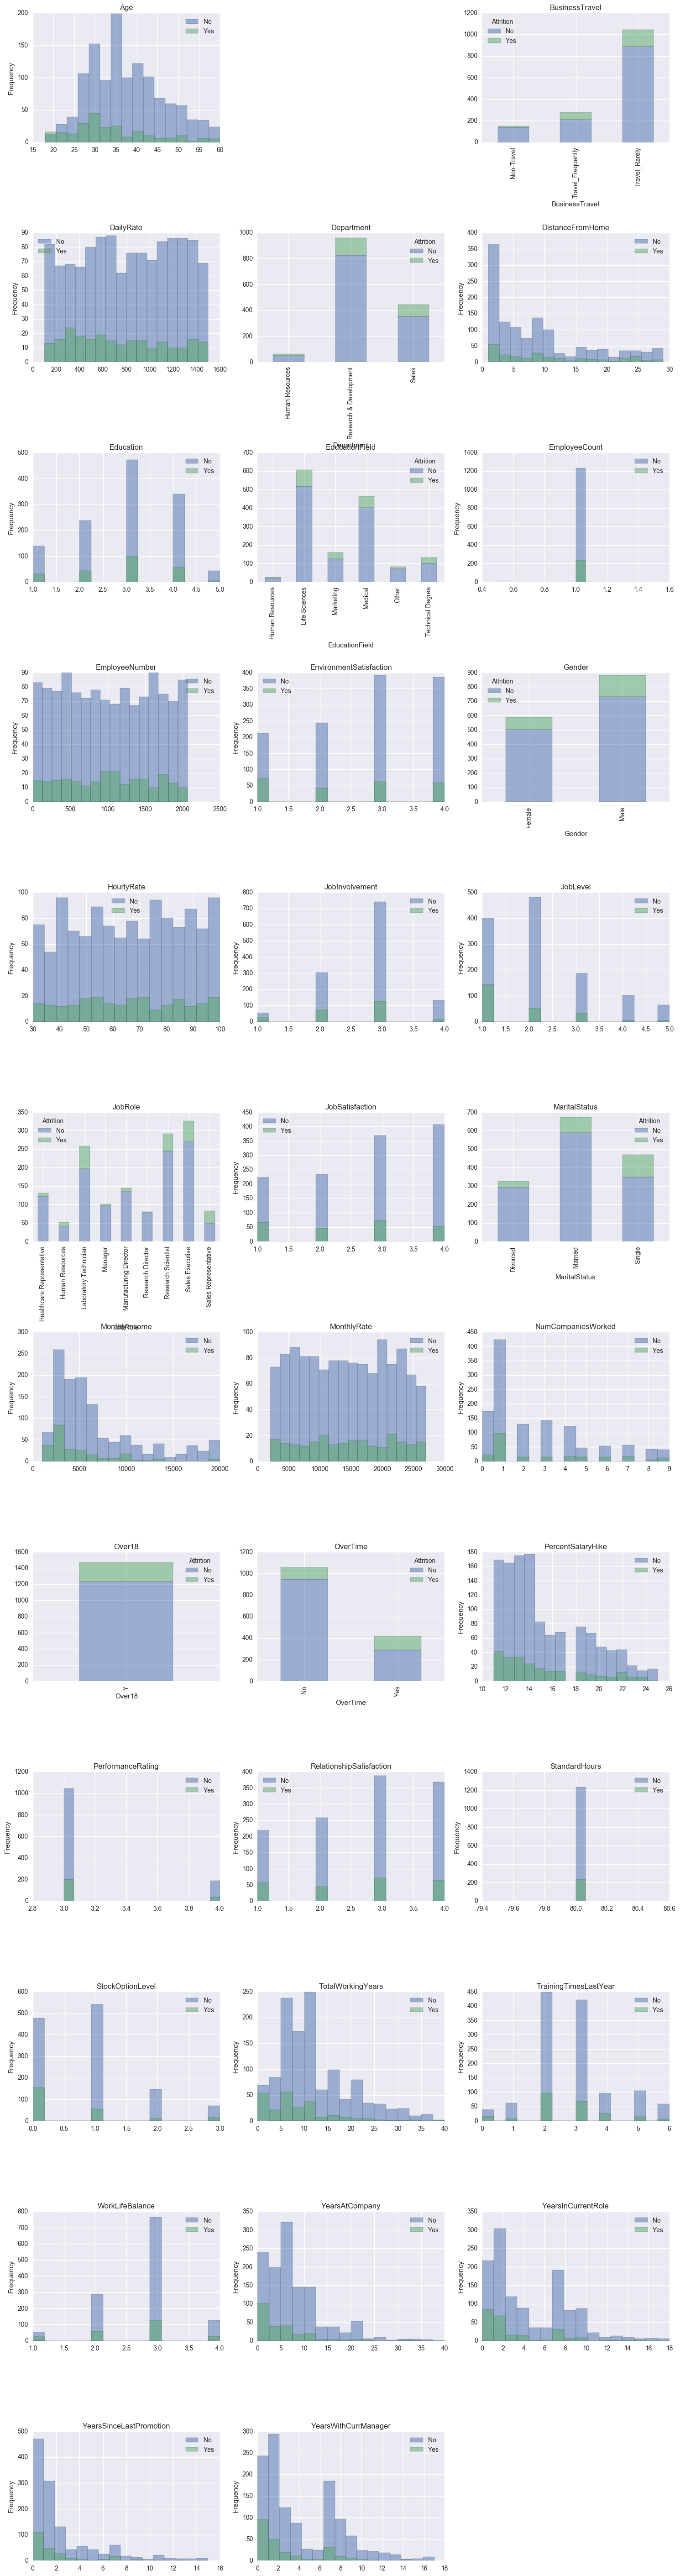

In [4]:
%matplotlib inline
import matplotlib
#matplotlib.style.use('ggplot')

import math
from ggplot import *
fig = plt.figure(figsize=(18, 72))
cols = 3
label_col = 'Attrition'

# Draw correlation plots per column
rows = math.ceil(float(attrition_pd.shape[1]) / cols)
for i, column in enumerate(attrition_pd.columns):
    if column.lower() == label_col.lower():
        continue
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if attrition_pd.dtypes[column] == np.object:
        cts = attrition_pd[[label_col, column]]
        cts = cts.groupby([label_col, column]).size()
        cts.unstack().T.plot(kind='bar', ax=ax, stacked=True, alpha=0.5)
    else:
        cts = attrition_pd[[label_col, column]]
        (xmin, xmax) = (min(cts[column].tolist()), max(cts[column].tolist()))
        cts.groupby(label_col)[column].plot(
            bins=16,
            kind='hist',
            stacked=True,
            alpha=0.5,
            legend=True,
            ax=ax,
            range=[xmin, xmax])

# Display plots
plt.subplots_adjust(hspace=0.7, wspace=0.2)

## 2.1 Feature Selection
By looking at the plots, and tallying with the hypothesis, can we validate we are along the right direction?

Here is notable visual observations we find (we will confirm statistically later) --
1. Age -- Older individuals ~55 years old do not attrite much.
2. DistanceFromHome -- longer commutes ~25 miles seem to attrite.
3. Education -- Individuals with doctoral degree do not attrite.
4. EmployeeCount, Over18, StandardHours -- they all exhibit an arity of 1 with no variance. These attributes are rubbish since we do not have any negative/variant examples.
5. EmployeeNumber -- is an ID attribute and useless as hypothesized
6. All satisfaction scores, as rightly hypothesized, exhibit higher attrition when satisfaction scores are lower. We still need a way to consolidate the three scores into one if possible.
7. All rates (daily, hourly, monthly) do not seem to show substantive patterns.
8. Singles show higher attrition as they churn faster.
9. Lower involvement rates seem to attrite more.
10. Sales and technicians attrite relatively more than other roles.
11. Lower monthly incomes -- no surprises -- do attrite and move to other opportunities.
12. NumCompaniesWorked -- people that have only had one or two jobs want to be adventurous.
13. Overtime -- people that are eligible for overtime (non exempt (fulltime?)) certainly seem to exhibit higher attrition pattern.
14. PercentSalaryHike -- people that received lower raises of course tend to move on.
15. Peformance Rating -- people with outstanding performance are recognized and rewarded; therefore attrite less. But we only see employees receiving excellent and outstanding ratings despite a wider range. So we have to renormalize the scale for better representation. Since the rating is already coded an ordinal attribute, we may be ok leaving as is too.
16. Lower stock option levels lead to higher attrition.
17. TotalWorkingYears -- people with approximately &lt;10 years attrite more. This variable is indeed confounded by age, marital status, experience, and YearsAtCompany perhaps!
18. TrainingTimesLastYear -- employees that do not seek training (are too snobby or too unskilled); and ones with 2-3 trainings seem to exhibit churn as skills are either too stale or improved beyond being applicable to current role.
19. YearsAtCompany and YearsInCurrentRole -- shorter experience window, especially in the first two years, seems to suggest quick attrition. This is understandable as new roles/employees are disconnected from business and usually take time to familiarize with the organization, business dynamics.
20. YearsSinceLastPromotion -- people with relatively long time since recent promotions seem to attrite less; perhaps they are just coasting in the current job.
21. YearsWithCurrentManager -- employees develop a trust with management in ~5 years. Before that, the lack of trust perhaps leads to attrition because of a clear alignment with management. Some individuals perhaps seek a change after a long term trust relationship too; so a few attrites do occur at the sixth year.

In [5]:
# Aligned with our few observations, let us take some actions and weed out useless attributes
df = attrition_pd.copy()
# Remove ID attributes and the attributes that do not have a variance
# See observations above for justification
df.drop('EmployeeCount', axis=1, inplace=True)
df.drop('EmployeeNumber', axis=1, inplace=True)
df.drop('Over18', axis=1, inplace=True)
df.drop('StandardHours', axis=1, inplace=True)

## 3. Model Building
Our exploration has given us a chance to gauge a few attributes and their characteristics. We have imputed and filtered values as needed.

Of the many attributes that seem to impact the attrition outcome, we do not know which is most discerning predictor. To discern, let us build a model...

We will be using a simple decision tree to investigate the predictor strength. We choose decision tree because we want explainability and palatibility of our model. Since decision tree works alright with categorical, ordinal, and continuous data, we are good so far with the data.

Alas, sklearn however does require us to map categorical variables into one-hot encoded floats aka trump -> [1, 0] and clinton -> [0, 1] where the first-bit indicates trump and second-bit indicates clinton. Numerics and ordinals are fine.

In [6]:
# Let us one-hot encode the data
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split the testset into a 90-10 split for training and testing
# Also remove all binary attributes and scale ordinal variables into 0-1 range
one_hot_encoded = pd.get_dummies(df).drop(
    label_col + '_No',
    axis=1).rename(columns={label_col + '_Yes': label_col}).drop(
        'OverTime_No', axis=1).rename(columns={'OverTime_Yes': 'OverTime'})

# Display the data set
pd_display(one_hot_encoded, "The dataset encoded")

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,Age,DailyRate,DistanceFromHome,Education,...,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime
0,41,1102,1,2,...,0,0,1,1
1,49,279,8,1,...,0,1,0,0
2,37,1373,2,2,...,0,0,1,1
...,...,...,...,...,...,...,...,...,...
1467,27,155,4,3,...,0,1,0,1
1468,49,1023,2,3,...,0,1,0,0
1469,34,628,8,3,...,0,1,0,0


In [7]:
# Define shortcuts for separating X and Y from pandas dataframe
X_set = lambda df: df.drop([label_col], axis=1)
Y_set = lambda df: df[label_col]

# Create a stratified KFold so you may repeat training instances randomized
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)

# Create empty test and training catalog
train_idx = []
test_idx = []

# Across each stratified fold, keep track of training records versus test records
for train, test in skf.split(X_set(one_hot_encoded), Y_set(one_hot_encoded)):
    train_idx.extend(train)
    test_idx.extend(test)
    
#Let us separate the training X and test X
X_train, y_train, X_test, y_test = (
    X_set(one_hot_encoded).iloc[train_idx], Y_set(one_hot_encoded).iloc[train_idx],
    X_set(one_hot_encoded).iloc[test_idx], Y_set(one_hot_encoded).iloc[test_idx])

# Let us preview the data
pd_display(X_train,
           "Training data normalized and ommitted of the prediction label")

,Age,DailyRate,DistanceFromHome,Education,...,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime
136,51,1150,8,4,...,0,0,1,0
140,32,1033,9,3,...,0,0,1,0
150,40,1395,26,3,...,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1325,42,1142,8,3,...,0,0,1,0
1327,46,1319,3,3,...,1,0,0,0
1328,27,728,23,1,...,0,1,0,0


Using the gradient boosted tree (the ensemble method) is...

In [8]:
#Let us use Gradient Boosted Tree Classifier (prediction of a yes/no attrition) model -- a decision tree implementation
from sklearn import ensemble
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import *

# Fit classifier params
params = {'n_estimators': 400, 'max_depth': 3 }

# Create classifier
clf = ensemble.GradientBoostingClassifier(learning_rate=0.01, **params)

# Train
clf.fit(X_train, y_train)

# Predict on testset and verify accuracy
acc = clf.score(X_test, y_test)

# Print
HTML("<h3 align='center'>Accuracy with Ensemble Methods is <u>{:.2f}%</u></h3>".format(acc * 100))

If we used a logistic regression model instead...

In [9]:
from sklearn import linear_model, datasets, metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=100.0)

# Train and predict the outcomes for test set
acc1 = logistic_classifier.fit(X_train, y_train).score(X_test, y_test)

# Print
HTML("<h3 align='center'>Accuracy with Logistic Regression is <u>{:.2f}%</u></h3>".format(acc1 * 100))

## Feature Importances

What features seem to be explaining the attrition most?

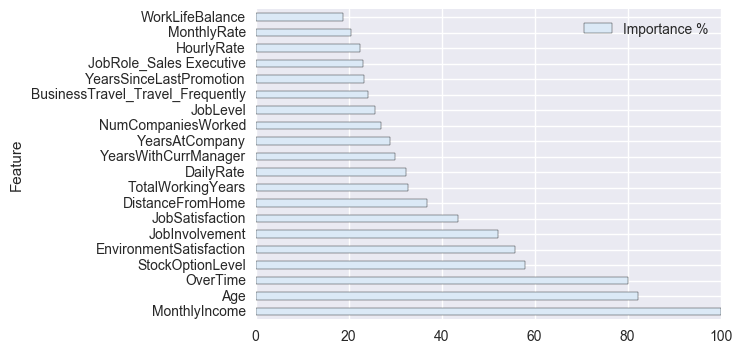

In [10]:
%matplotlib inline

# Plot feature importance normalized to a 100% scale
importances = pd.DataFrame(
    zip(X_train.columns.values, 100 * clf.feature_importances_ /
        clf.feature_importances_.max()),
    columns=['Feature', 'Importance %']).sort_values(
        ['Importance %'], ascending=[False])

# Chart most important features predicting the attrition outcome
sns.set_palette("Blues")
importances.head(20).plot(kind='barh', x='Feature', y='Importance %');

## 3.1 Is the model any good?

,0,1
0,1230,3
1,145,92


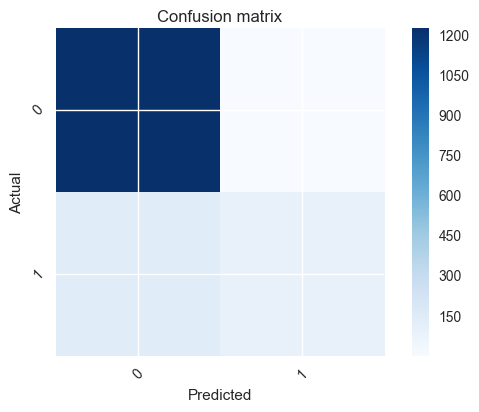

In [11]:
#Let us see how we predicted. What false positives and true negatives did we yield...
from sklearn.metrics import confusion_matrix

# Predict the attrition outcomes on the test set
y_pred = clf.predict(X_test)

# Draw the confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):
    # Show the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # Put labels on axis
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels, rotation=45)
    # Pack it together
    plt.tight_layout()
    
    # Render the DataFrame as a table for easy view
    cmpd = pd.DataFrame(cm, columns=labels)
    cmpd.index = labels
    display(HTML('<b align="center">Confusion matrix</b>'))
    display(cmpd)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')


# Labels
labels = [0, 1]
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Show the confusion matrix
plt.figure()
plot_confusion_matrix(cm, labels=labels)
plt.show()

How do we interpret these results?
* If you penalize both false-positives (where the model predicted the employee will attrite when indeed they did not!) and false-negatives (where the model predicted the employee will not attrite when they indeed did!), then the model accuracy is operating with ~85% accuracy. Btw, in real world, it is more detrimental to safely assume that an employee will not attrite when they do -- and one would want to err towards caution -- therefore be more intolerant to false negatives.
* To read a confusion matrix heuristically, if you treat the visualization of a matrix as a matrix, the elements along the diagonal must be large numbers and there should not be any spillage outside the diagonal. Spillage will seep to non diagonal elements which are indication that model and the real-world do not align. So it should be "dark" along the diagonal and white along non-diagonals. Any seepage above the diagonal (upper triangular matrix) is false-postive and under the diagonal (lower triangular matrix) is false negative.
* In our case, we seem to be falling into the fallacy of predicting an employee will not attrite when they indeed do in 15 test cases, and that is not good. Predicting ~3 employees as attriting when they do not is not so much a challenge if the company values employee retention.

## 4. Reading/explaining the model

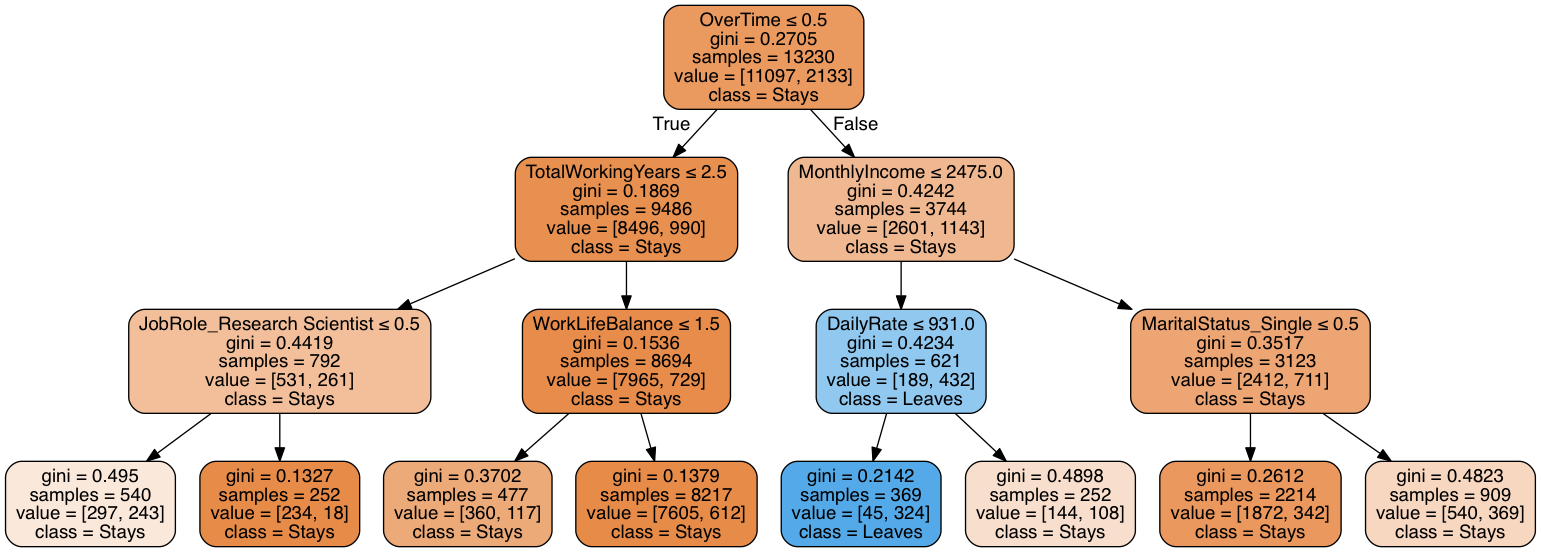

In [12]:
# What does our data decision tree look like...
# Since GBT is an ensemble of randomforests/decisiontrees, we will refit the data just to render on the screen
from IPython.display import Image
import pydot
from sklearn import tree
from sklearn.externals.six import StringIO
from sklearn import tree

dtree = tree.DecisionTreeClassifier(max_depth=3)
dtree = dtree.fit(X_train, y_train)

dot_data = StringIO()
with open("output.dot", "w") as output_file:
    tree.export_graphviz(
        dtree,
        out_file=output_file,
        filled=True,
        rounded=True,
        feature_names=X_train.columns.values,
        class_names=['Stays', 'Leaves'],
        special_characters=True)
from os import system
system('dot -Tpng -o dtree2.png output.dot')
Image("dtree2.png")
#Double click on the image if you care.

## 4.1 Interpreting the chart

What does the decision tree really tell us? Focus on leaf nodes that show class="Leaves". The class of a node is assigned as a "winner takes all" churn or retention class. 

Traversing the left-most "leaves" branch, it suggests that fulltime non-research scientists with relatively smaller experience of less than 1.5 years employees attrite just as much as they stay. So age and profession of the fulltime employee base is a factor of concern warranting better incentives and cross-opportunities for young non-research trainees in the organization. 

Traversing the other leaves branch, it suggests that young fulltime employees under 34 years with lower income of less than $3750 are showing higher propensity to leave. It warrants better incentives for younger employees.

Similarly, not shown here, another rendition of the tree suggested exempt employees that do not qualify for overtime and make smaller daily rates leave as well.

All this leads to simple outcomes -- 

1. employees with smaller incentives leave.
2. similarly employees in non-research (aka non-innovative fields) leave. 
3. younger and single non-exempt employees leave.

To save employees from churning, offer better rotational opportunities, financial incentives, and contract-to-hire opportunities.

## 5. Scoring

Now that we have a model, one that performs ~85% accuracy, can we now predict for new employees (or current employees as they age) if/when they attrite? YES!

In [13]:
#For the purposes of this demo, let us assume test data is indeed our scoring data. You want to ideally score on an unseen data...
#Predict the attrition likelihood
y_pred = clf.predict(X_test)
emit = X_test.copy()
emit['Really Attrited'] = y_test
emit['Predicted Attrited'] = y_pred

#Show the likelihoods
pd_display(
    emit[emit['Predicted Attrited']==1].drop_duplicates(),
    "These are the predicted churn outcomes of existing employee base. Please reach out the employees that have prediction of attrition = 1"
)

,Age,DailyRate,DistanceFromHome,Education,...,MaritalStatus_Single,OverTime,Really Attrited,Predicted Attrited
14,28,103,24,3,...,1,1,1,1
26,32,1125,16,1,...,1,1,1,1
34,24,813,1,3,...,0,1,1,1
...,...,...,...,...,...,...,...,...,...
1396,53,1168,24,4,...,1,1,1,1
1436,21,501,5,1,...,1,1,0,1
1438,23,638,9,3,...,0,0,1,1


## Conclusion

A simple attrition analysis model. This is a purely quantitative model that looks at attributes.

Survival models that predict outcomes based on prior "activities" (telephone calls, HR escalations, paystub downloads etc) also play a critical role in churn analysis. We do not consider those here although we do call you to search for nPath analysis (http://blogs.sas.com/content/sascom/2014/08/19/path-analysis-with-sas-visual-analytics/) to learn more about a few of these survival models.